### Evaluation of the effect of various aggressive media, their temperatures, and exposure time on the strength of a material using ANCOVA and regression analysis
The purpose of this study is to examine the effects of 3 different aggressive media, their temperatures, exposure time, and their interactions on the mechanical properties of a material. In order to do it, a statistical approach using ANCOVA multiple linear regression analysis is utilized. 

First of all, let's import our data by pandas' `read_csv()` function.

In [1]:
import pandas as pd

# DataFrame from a 'csv' file 
Comp_df = pd.read_csv('Comp.csv')

Comp_df.head()

,Material,Solution,Temperature,Time,Tb_Mpa
0,ST,Oil,22,0,11.741106
1,ST,Oil,22,0,11.313492
2,ST,Oil,22,0,11.627972
3,ST,Oil,60,0,11.741106
4,ST,Oil,60,0,11.313492


As we may see, the above table has 5 columns: the material name 'Material', solution name 'Solution', its temperature 'Temperature', exposure time inside a solution 'Time', and strength values 'Tb_Mpa'.  The last column is the output variable, others are input ones.

Well so let's drop the first column because we have only one material here.

In [2]:
# Drop a column
Comp_df = Comp_df.drop(['Material'], axis=1)

In order to see the data distribution, skewness, and outliers, the box plot chart was plotted.

Text(0, 0.5, 'Strength, $F^{sbs}$ (MPa)')

<Figure size 432x288 with 0 Axes>

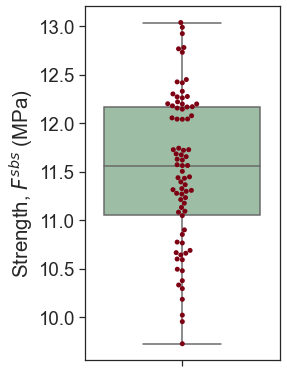

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

f = plt.figure()
sns.set(font_scale=1.7)
sns.set_style("ticks")
f, ax = plt.subplots(figsize=(3.5, 6.5))

# Box plot chart
ax = sns.boxplot(y='Tb_Mpa', data=Comp_df[24:], color='#99c2a2')
ax = sns.swarmplot(y="Tb_Mpa", data=Comp_df[24:], color='#7d0013')  

plt.ylabel("Strength, $F^{sbs}$ (MPa)")
# To save the diagrams, use the code snippet below
#f.savefig("Results\BoxPlot_strength.png", bbox_inches='tight', dpi=600)

One can see that strength values are not too skewed and there are no outliers, therefore we can accept the whole dataset.

Our DataFrame has not only quantitative but also categorical variables, therefore to apply ANCOVA, we need to re-code the categorical variable with 3 kinds of solutions as 3 new columns with 0 and 1. Using the function `prep_dat` the variables are coded 0 for any case that does not match the variable name and 1 for any case that does match the variable name. 

In [7]:
from sklearn.preprocessing import OneHotEncoder

def prep_dat(df):
    '''The function converts categorical variables to numerical by "one-hot encoder".'''
    # Input variables
    X = (df[df.columns[:-1]]).copy()
    
    # List of column names with categorical variables
    object_cols = list(((X.dtypes == 'object')[(X.dtypes == 'object')]).index)
    
    # Apply one-hot encoder to each column with categorical data
    OH_encoder = OneHotEncoder(sparse=False)
    OH_cols_X = pd.DataFrame(OH_encoder.fit_transform(X[object_cols]))
    
    # One-hot encoding removed index; put it back
    OH_cols_X.index = X.index
    
    # Get new column names
    OH_cols_X.columns = OH_encoder.get_feature_names(object_cols)

    # Remove categorical columns (will replace with one-hot encoding)
    num_X = X.drop(object_cols, axis=1)

    # Add one-hot encoded columns to numerical features
    OH_X = pd.concat([OH_cols_X, num_X], axis=1)
    
    return OH_X

In [8]:
# Convert categorical variables to numerical
Comp_df_OH = prep_dat(Comp_df)
Comp_df_OH.head()

,Solution_Industrial_water,Solution_Oil,Solution_Sea_water,Temperature,Time
0,0.0,1.0,0.0,22,0
1,0.0,1.0,0.0,22,0
2,0.0,1.0,0.0,22,0
3,0.0,1.0,0.0,60,0
4,0.0,1.0,0.0,60,0


Next, to avoid multi-collinearity, we have to drop one of the one-hot columns

In [9]:
# Drop a column
Comp_df_OH.drop('Solution_Oil', axis=1, inplace=True)
Comp_df_OH.head()

,Solution_Industrial_water,Solution_Sea_water,Temperature,Time
0,0.0,0.0,22,0
1,0.0,0.0,22,0
2,0.0,0.0,22,0
3,0.0,0.0,60,0
4,0.0,0.0,60,0


First of all, let's examine the interaction ANCOVA model. By doing this, we have to add new columns with interactions between the different solutions, their temperature, and exposure time.

In [13]:
# Take into account interaction between input variables
Comp_df_OH_inter = pd.concat([Comp_df_OH,
      pd.DataFrame({'Temperature*Time': Comp_df_OH['Temperature']*Comp_df_OH['Time']}),
      pd.DataFrame({'Industrial_water*Temperature*Time': 
          Comp_df_OH['Solution_Industrial_water']*Comp_df_OH['Temperature']*Comp_df_OH['Time']}),
      pd.DataFrame({'Industrial_water*Temperature': Comp_df_OH['Solution_Industrial_water']*Comp_df_OH['Temperature']}),
      pd.DataFrame({'Industrial_water*Time': Comp_df_OH['Solution_Industrial_water']*Comp_df_OH['Time']}),
      pd.DataFrame({'Sea_water*Temperature*Time': 
          Comp_df_OH['Solution_Sea_water']*Comp_df_OH['Temperature']*Comp_df_OH['Time']}),
      pd.DataFrame({'Sea_water*Temperature': Comp_df_OH['Solution_Sea_water']*Comp_df_OH['Temperature']}),
      pd.DataFrame({'Sea_water*Time': Comp_df_OH['Solution_Sea_water']*Comp_df_OH['Time']})], 1)

However, it is evident that aggressive media, as well as its temperature, do not affect the results at an exposure time of 0 days. Consequently, these input variables can be considered insignificant and removed from the interaction model. Thus, ‘Ind. Water’, ‘Sea water’, ‘Temp’, ‘Ind. water×Temp’, and ‘Sea water×Temp’ variables were not taken into account in order to avoid high multicollinearity.

In [19]:
Comp_df_OH_inter = Comp_df_OH_inter.drop(['Solution_Industrial_water', 'Solution_Sea_water', 'Temperature', 
                                           'Industrial_water*Temperature', 'Sea_water*Temperature'], axis=1).copy()

In [20]:
Comp_df_OH_inter.head()

,Time,Temperature*Time,Industrial_water*Temperature*Time,Industrial_water*Time,Sea_water*Temperature*Time,Sea_water*Time
0,0,0,0.0,0.0,0.0,0.0
1,0,0,0.0,0.0,0.0,0.0
2,0,0,0.0,0.0,0.0,0.0
3,0,0,0.0,0.0,0.0,0.0
4,0,0,0.0,0.0,0.0,0.0


Before regression analysis, the data has to be normalized or standardized, but our dataset is small, so we can skip this step.

In [21]:
# Add the output varible
Comp_df_OH_inter = pd.concat([Comp_df_OH_inter, Comp_df[['Tb_Mpa']]], 1)
Comp_df_OH_inter.head()

,Time,Temperature*Time,Industrial_water*Temperature*Time,Industrial_water*Time,Sea_water*Temperature*Time,Sea_water*Time,Tb_Mpa
0,0,0,0.0,0.0,0.0,0.0,11.741106
1,0,0,0.0,0.0,0.0,0.0,11.313492
2,0,0,0.0,0.0,0.0,0.0,11.627972
3,0,0,0.0,0.0,0.0,0.0,11.741106
4,0,0,0.0,0.0,0.0,0.0,11.313492


The next step is to conduct regression analysis.

In [22]:
import statsmodels.api as sm

def reg_an(df):
    """The function for multiple linear regression analysis"""    
    # X and y values for modeling
    X = df[df.columns[:-1]]
    y = df[df.columns[-1]]
    # Adding a constant
    X = sm.add_constant(X) 

    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    
    # Degrees of freedom 
    DF = (len(predictions)-len(model.params))
    # The Standard Error of Estimate
    SEE = (sum((predictions - y)**2)/DF)**0.5

    print_model = model.summary()
    return (model.pvalues, model.params, print_model, predictions, SEE)

In [23]:
pval_1, param_1, print_mod_1, pred_1, SEE_1 = reg_an(Comp_df_OH_inter)

print('The Standard Error of Estimate:', SEE_1.__round__(4))
print(print_mod_1)

The Standard Error of Estimate: 0.4078
                            OLS Regression Results                            
Dep. Variable:                 Tb_Mpa   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     31.24
Date:                Wed, 01 Sep 2021   Prob (F-statistic):           1.80e-20
Time:                        12:44:29   Log-Likelihood:                -49.606
No. Observations:                 102   AIC:                             113.2
Df Residuals:                      95   BIC:                             131.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

To save the regression data, we can use the code snippet below.

In [ ]:
pd.DataFrame(print_mod.tables[1]).to_excel("ANCOVA_Regres_1.xlsx", index=False, header=None)

Then, let's plot graphs with predictions.

In [24]:
def grouped_df(data, column, label):
    '''The function splits a pandas DataFrame according to a column and returns data with "label" values in the column.'''
    group = data.groupby(column)
    return group.get_group(label)

In [26]:
import numpy as np

def plot_grap_mult(df, X_col, Extr_col, pred):
    '''The function plots prediction diagrams according to regression analysis'''
    # Add new column with temperature information
    df = pd.concat([
        df, 
        pd.DataFrame({"Extr_col":('T = ' + df[Extr_col].astype(str) + " C")})
        ], axis=1)
    
    for env in (df['Solution']).unique():
        df_env = grouped_df(df, 'Solution', env)
        
        f = plt.figure()
        
        sns.set(font_scale=1.5)
        sns.set_style("ticks")
        f, ax = plt.subplots(figsize=(8, 5))
        
        # Scatter plot
        sns.scatterplot(x=df_env[X_col], y=df_env['Tb_Mpa'], hue=np.array(df_env['Extr_col']), s=70)
        
        for temp in (df_env['Extr_col']).unique():
            df_env_temp = grouped_df(df_env, 'Extr_col', temp)

            # Approximation of the scatter plot by the regression model
            X = df_env_temp[X_col]
            Y = pred[X.index]
            sns.lineplot(X, Y)       
        
        plt.xlabel("Exposure time, $t$ (days)")
        plt.ylabel("Strength, $F^{sbs}$ (MPa)")
        
        # To save the diagrams, use the code snippet below
        #f.savefig(str(env) + ".png", bbox_inches='tight', dpi=600)

<Figure size 432x288 with 0 Axes>

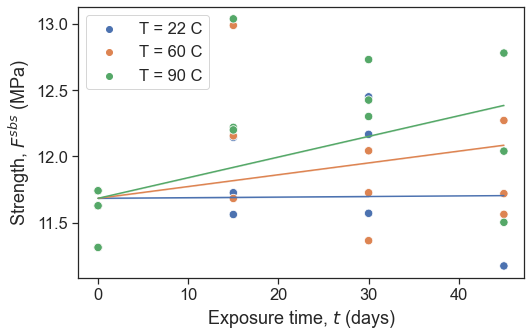

<Figure size 432x288 with 0 Axes>

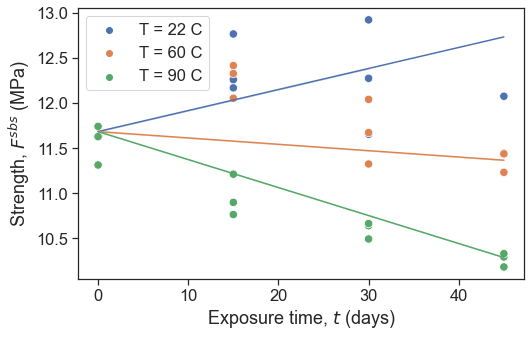

<Figure size 432x288 with 0 Axes>

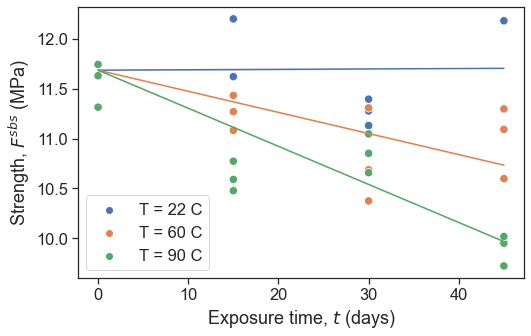

In [27]:
plot_grap_mult(Comp_df, 'Time', 'Temperature', pred_1)

We demonstrated the model with interactions above, but how well the additive model is (without interaction effects). Let's find it out.

In [28]:
# Add the output varible
Comp_df_OH = pd.concat([Comp_df_OH, Comp_df[['Tb_Mpa']]], 1)

In [29]:
pval_2, mod_par_2, print_mod_2, pred_2, SEE_2 = reg_an(Comp_df_OH)

print('The Standard Error of Estimate:', SEE_2.__round__(4))
print(print_mod_2)

The Standard Error of Estimate: 0.5546
                            OLS Regression Results                            
Dep. Variable:                 Tb_Mpa   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     13.92
Date:                Wed, 01 Sep 2021   Prob (F-statistic):           5.20e-09
Time:                        12:47:13   Log-Likelihood:                -82.041
No. Observations:                 102   AIC:                             174.1
Df Residuals:                      97   BIC:                             187.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

The additive and full ANCOVA models explain 34 % and 64 % of the variability in test scores respectively (adjusted R2 are 0.338 and 0.642), and the standard error of estimate (0.55 and 0.41) represents how far data fall from the regression predictions. Hereby, it suggests that the second model is the better one. In addition, one can see that the test has F statistic of 31.24 and 13.92 with p-values of less than 0.001 for additive and interaction models respectively. Accordingly, it shows the necessity of these models over an intercept-only model that predicts the average output for all the data.